In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Subset
import numpy as np
from torchvision.models import ResNet18_Weights
import torch.optim as optim
import torch.nn as nn
import importnb
with importnb.Notebook():
    from matrix_based_entropy_estimators import IT_calculator



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

pet_classes = [
    "Abyssinian", "Bengal", "Birman", "Bombay", "British_Shorthair", "Egyptian_Mau",
    "Maine_Coon", "Persian", "Ragdoll", "Russian_Blue", "Siamese", "Sphynx",
    "american_bulldog", "american_pit_bull_terrier", "basset_hound", "beagle", "boxer",
    "chihuahua", "english_cocker_spaniel", "english_setter", "german_shorthaired",
    "great_pyrenees", "havanese", "japanese_chin", "keeshond", "leonberger",
    "miniature_pinscher", "newfoundland", "pomeranian", "pug", "saint_bernard",
    "samoyed", "scottish_terrier", "shiba_inu", "staffordshire_bull_terrier",
    "wheaten_terrier", "yorkshire_terrier"
]

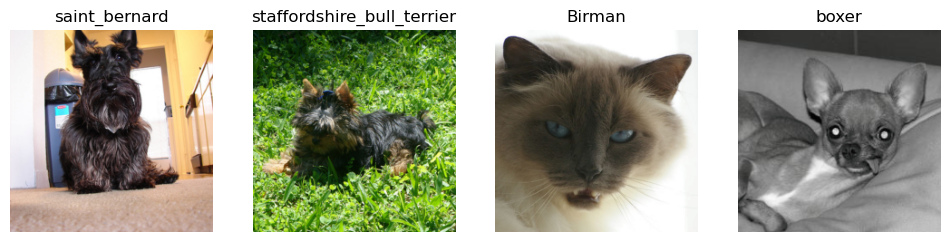

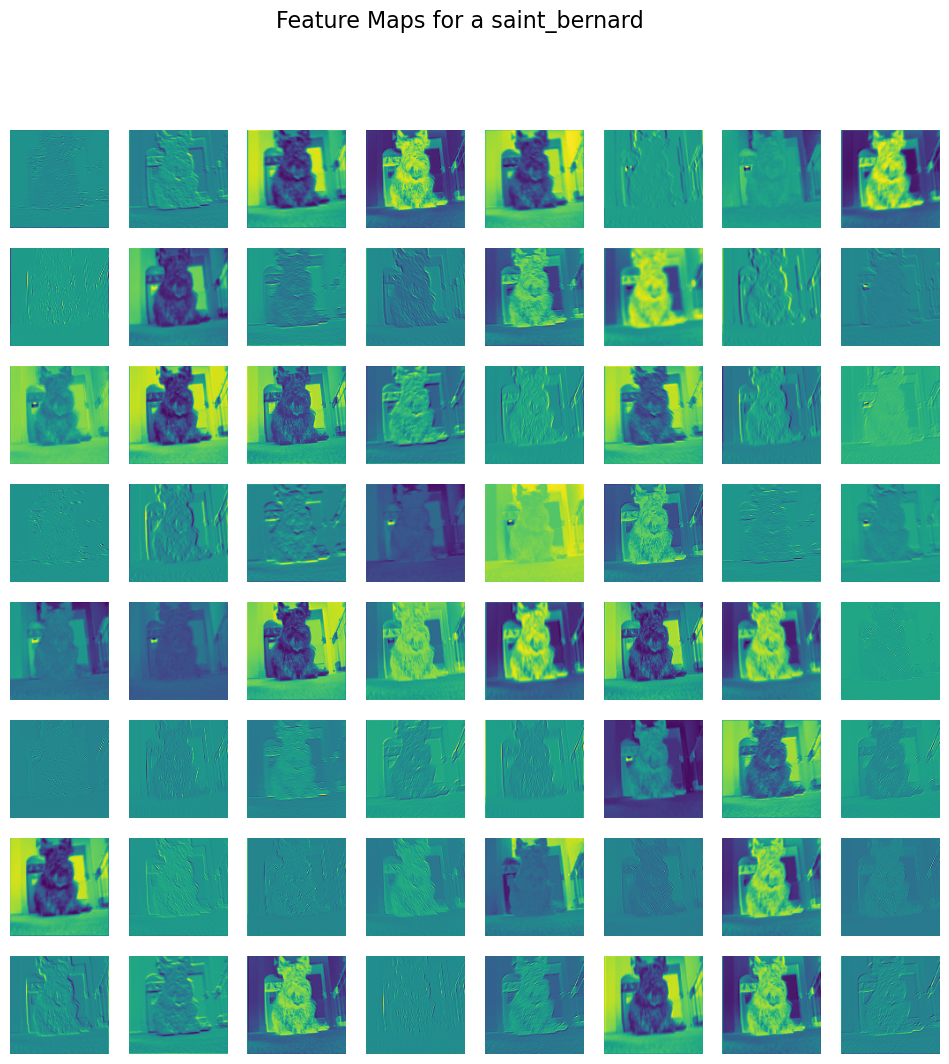

In [4]:
# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root='./data/Oxford Pet/', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create a smaller subset of the dataset
subset_size = 100  # Define the size of your subset
indices = np.random.choice(len(dataset), subset_size, replace=False)
subset_dataset = Subset(dataset, indices)

# Now, create a DataLoader for the subset
subset_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True)

# Load a pretrained ResNet18 model
weights = ResNet18_Weights.DEFAULT  # or choose a specific weights enum as needed
model = models.resnet18(weights=weights)
model.eval() # Set the model to evaluation mode

# Register a forward hook to capture the outputs of the first layer
activations = []
def hook_fn(module, input, output):
    activations.append(output)

first_layer = model.conv1
handle = first_layer.register_forward_hook(hook_fn)

# Get a batch of images and labels
images, labels = next(iter(subset_loader))

# Forward pass through the model
output = model(images)

# Remove the hook
handle.remove()

# Visualize the raw images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for idx, (img, label) in enumerate(zip(images, labels)):
    # Invert normalization for visualization
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = img.clamp(0, 1)
    img = transforms.functional.to_pil_image(img)
    axes[idx].imshow(img)
    axes[idx].set_title(pet_classes[label]) 
    axes[idx].axis('off')
plt.show()

# Visualize the feature maps from the first convolutional layer
# Select one of the images to visualize
img_index = 0

# Get the corresponding label for the title
sample_label_name = pet_classes[labels[img_index].item()]
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    # We take the first batch's activations ([img_index]) and the ith filter
    fmap = activations[0][img_index][i].detach().cpu()
    ax.imshow(fmap, cmap='viridis')
    ax.axis('off')
fig.suptitle(f'Feature Maps for a {sample_label_name}', fontsize=16)
plt.show()

In [5]:
full_dataset = datasets.ImageFolder(root='./data/Oxford Pet/', transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

weights = ResNet18_Weights.DEFAULT  # or choose a specific weights enum as needed
model = models.resnet18(weights=weights)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 37)  # Adjust the final layer to 37 classes

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
# num_epochs = 3  # Define the number of epochs
# for epoch in range(num_epochs):
#     model.train()  # Set the model to training mode
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
        
#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
    
#     print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# print('Finished Training')

# model_save_path = './trained_model/Resnet18_Pet_Data.pth'
# torch.save(model.state_dict(), model_save_path)

# print(f'Model state dictionary saved to {model_save_path}')

In [7]:
model.load_state_dict(torch.load('./trained_model/Resnet18_Pet_Data.pth'))
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 96.21109607577807%


In [ ]:
it_estimator = IT_calculator()
first_conv_layer = model.conv1
sample_size = 100  # Define your sample size
indices = torch.randperm(len(train_dataset))[:sample_size]
X, Y = zip(*[train_dataset[i] for i in indices])
X = torch.stack(X).to(device)  # Shape (sample_size, C, H, W)
Y = torch.tensor(Y).to(device)  # Shape (sample_size,)

# Forward pass through the first conv layer to get T
T = first_conv_layer(X)  # Shape (sample_size, num_of_filters, H, W)

# Reshape feature maps and inputs for mutual information calculation
# T_reshaped = T.view(T.size(1), -1).transpose(0, 1)  # Shape (sample_size, num_of_filters * H * W)
# X_reshaped = X.view(X.size(0), -1)  # Shape (sample_size, C * H * W)

T = T.float()
T_reshaped = T.permute(1, 0, 2, 3)
Y = Y.float()
X_reshaped = X.float()
num_of_filters = T_reshaped.shape[0]

# Calculate mutual information
mi_TX = torch.zeros(num_of_filters)
mi_TY = torch.zeros(num_of_filters)

for i in range(num_of_filters):
    # Compute MI between the feature map of the ith filter and the input data
    mi_TX[i] = it_estimator.MI(T_reshaped[i], X_reshaped)
    
    # Compute MI between the feature map of the ith filter and the labels
    mi_TY[i] = it_estimator.MI(T_reshaped[i], Y)

# Compute the criterion for each filter
criterion = mi_TX - 2 * mi_TY

# Sort filters by the criterion in ascending order
sorted_indices = criterion.argsort()

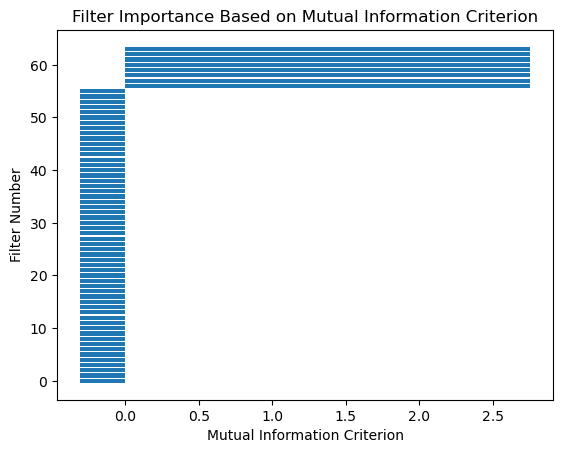

In [22]:
# Plot the bar chart
plt.barh(range(num_of_filters), criterion[sorted_indices].numpy())
plt.xlabel('Mutual Information Criterion')
plt.ylabel('Filter Number')
plt.title('Filter Importance Based on Mutual Information Criterion')
plt.show()

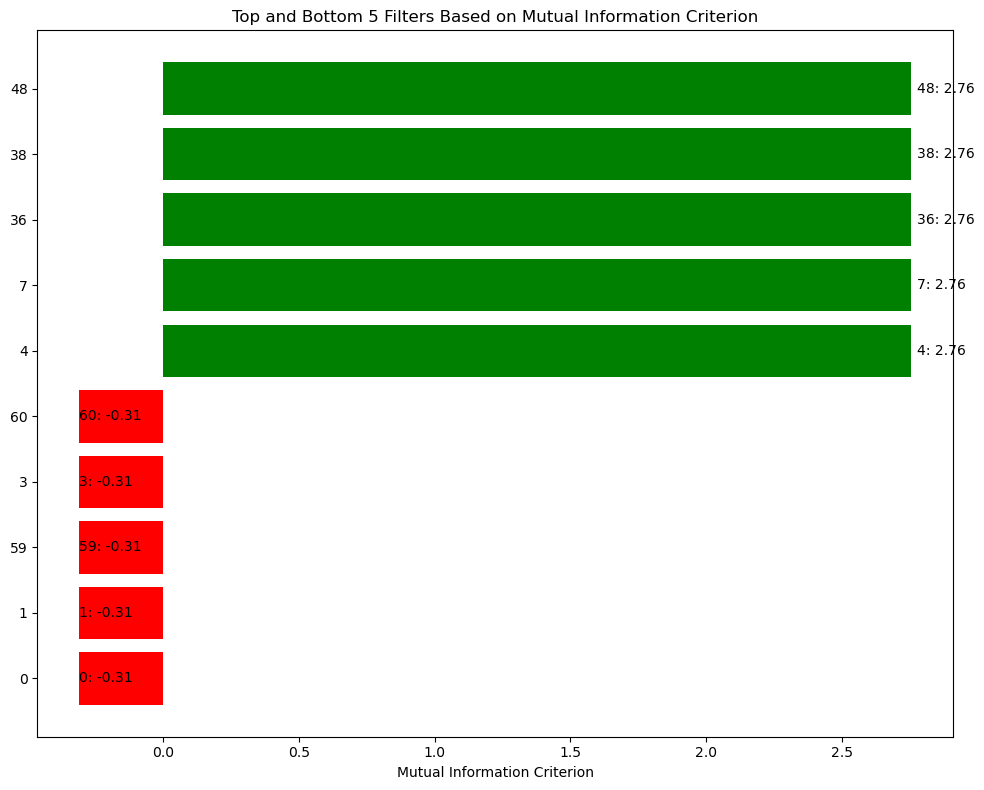

In [24]:
top_indices = sorted_indices[-5:]  # Last 5 values are the top ones since we sorted in ascending order
bottom_indices = sorted_indices[:5]  # First 5 values are the bottom ones

# Combine the top and bottom indices and corresponding criterion values
selected_indices = torch.cat((bottom_indices, top_indices))
selected_criterion = criterion[selected_indices].numpy()

# Corresponding filter numbers and indices for plotting
filter_labels = [f"{int(i)}" for i in selected_indices]

# Plot the bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(filter_labels, selected_criterion, color=['red' if i < 5 else 'green' for i in range(10)])
plt.xlabel('Mutual Information Criterion')
plt.title('Top and Bottom 5 Filters Based on Mutual Information Criterion')

# Add the criterion values on top of the bars
for bar, label in zip(bars, filter_labels):
    width = bar.get_width()
    label_x_pos = width if width < 0 else width + 0.02
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{label}: {width:.2f}', va='center')

# Make the plot nicer
plt.tight_layout()
plt.show()

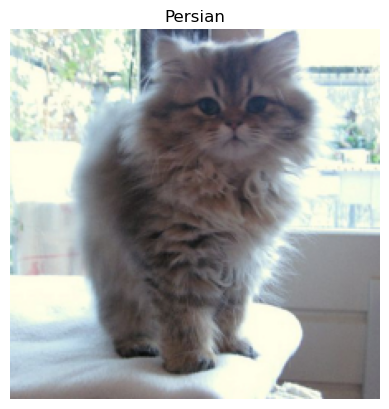

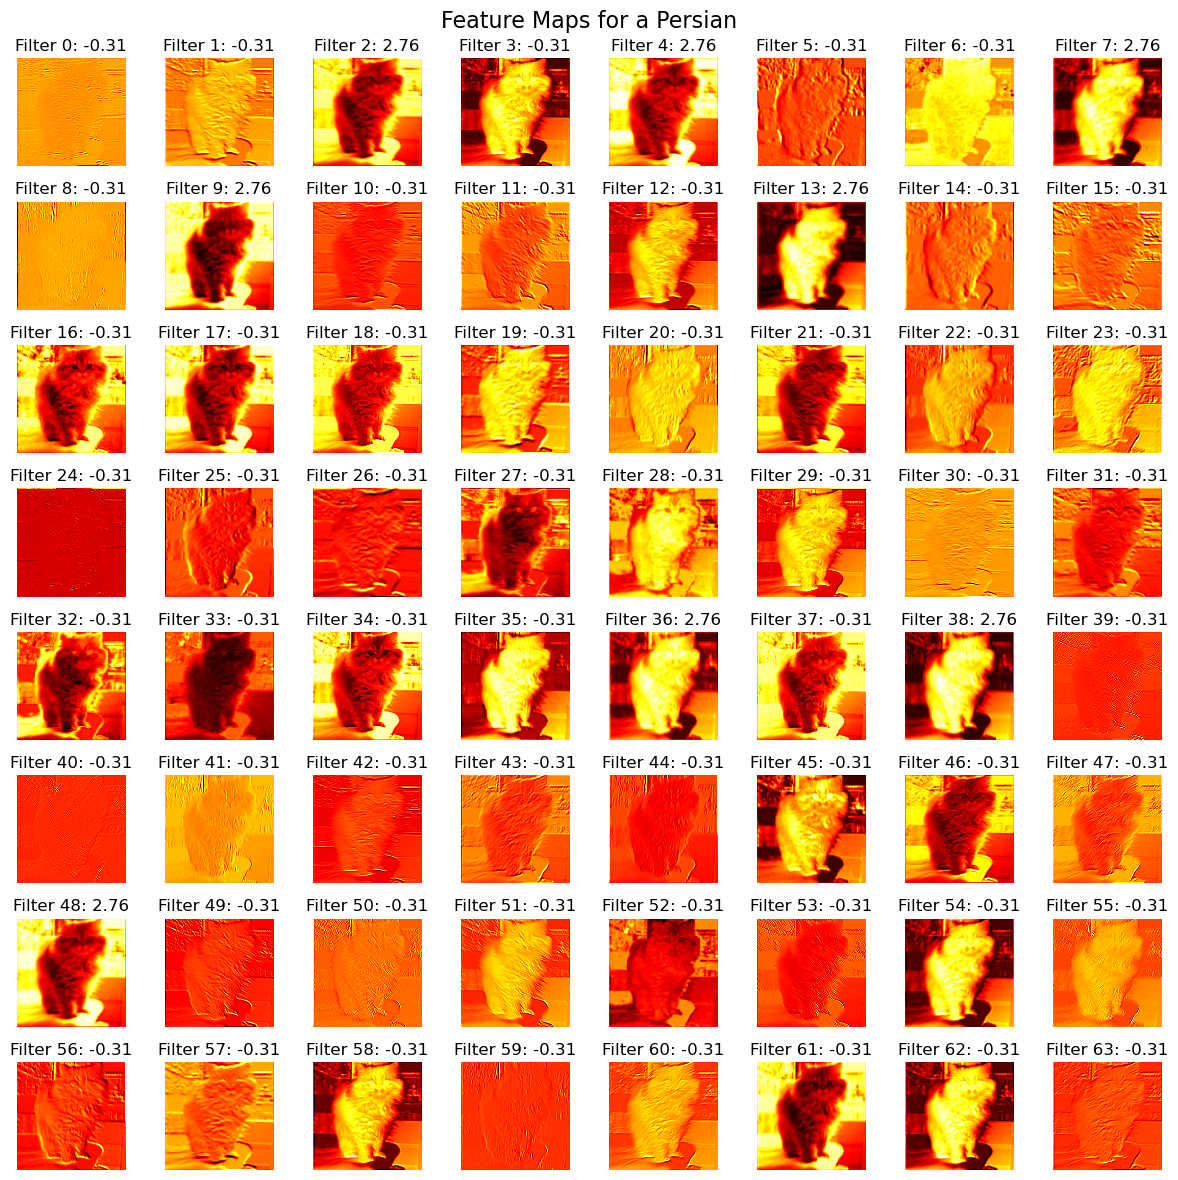

In [39]:
# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root='./data/Oxford Pet/', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create a smaller subset of the dataset
subset_size = 100  # Define the size of your subset
indices = np.random.choice(len(dataset), subset_size, replace=False)
subset_dataset = Subset(dataset, indices)

# Now, create a DataLoader for the subset
subset_loader = DataLoader(subset_dataset, batch_size=1, shuffle=True)

# Load a pretrained ResNet18 model
weights = ResNet18_Weights.DEFAULT  # or choose a specific weights enum as needed
model = models.resnet18(weights=weights)
model.eval() # Set the model to evaluation mode

# Register a forward hook to capture the outputs of the first layer
activations = []
def hook_fn(module, input, output):
    activations.append(output)

first_layer = model.conv1
handle = first_layer.register_forward_hook(hook_fn)

# Get a batch of images and labels
images, labels = next(iter(subset_loader))

# Forward pass through the model
output = model(images)

# Remove the hook
handle.remove()

# Visualize the raw images
# Visualize the raw images
fig = plt.figure()

    # Invert normalization for visualization
img = images[0] * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
img = img.clamp(0, 1)
img = transforms.functional.to_pil_image(img)
plt.imshow(img)
plt.title(pet_classes[labels[0]]) 
plt.axis('off')
plt.show()

# Visualize the feature maps from the first convolutional layer
# Select one of the images to visualize
img_index = 0

# Get the corresponding label for the title
sample_label_name = pet_classes[labels[img_index].item()]
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    # We take the first batch's activations ([img_index]) and the ith filter
    fmap = activations[0][img_index][i].detach().cpu()
    ax.imshow(fmap, cmap='hot', interpolation='nearest')
    ax.set_title(f'Filter {i}: {criterion[i]:.2f}')
    ax.axis('off')
fig.suptitle(f'Feature Maps for a {sample_label_name}', fontsize=16)
plt.tight_layout()
plt.show()